In [1]:
import time
import pandas as pd
import psycopg2 as pg2
import psycopg2.extras as extras

# Load and explore Excel table

In [2]:
data = pd.read_excel(
    'Sample - Superstore.xlsx', 
    parse_dates=['Order Date', 'Ship Date'], 
    dtype={'Postal Code': str}
)
data.columns = [col.lower().replace(' ', '_').replace('-', '_') for col in data.columns]

C:\Users\space\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   row_id         9994 non-null   int64         
 1   order_id       9994 non-null   object        
 2   order_date     9994 non-null   datetime64[ns]
 3   ship_date      9994 non-null   datetime64[ns]
 4   ship_mode      9994 non-null   object        
 5   customer_id    9994 non-null   object        
 6   customer_name  9994 non-null   object        
 7   segment        9994 non-null   object        
 8   country        9994 non-null   object        
 9   city           9994 non-null   object        
 10  state          9994 non-null   object        
 11  postal_code    9983 non-null   object        
 12  region         9994 non-null   object        
 13  product_id     9994 non-null   object        
 14  category       9994 non-null   object        
 15  sub_category   9994 n

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,product_id,category,sub_category,product_name,sales,quantity,discount,profit,person,returned
0,1,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,Cassandra Brandow,No
1,2,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,Cassandra Brandow,No
2,3,CA-2018-138688,2018-06-12,2018-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,Anna Andreadi,No
3,4,US-2017-108966,2017-10-11,2017-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,Cassandra Brandow,No
4,5,US-2017-108966,2017-10-11,2017-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,Cassandra Brandow,No


In [4]:
data[data['postal_code'].isna()][['state', 'city', 'postal_code']].drop_duplicates()

,state,city,postal_code
2234,Vermont,Burlington,NaN


In [5]:
data['postal_code'] = data['postal_code'].fillna('05401')

# Connection to PostgreSQL and insertion data to database

In [6]:
times = {}
counts = {}

In [7]:
conn = pg2.connect("dbname='de101_module2' user=postgres password=1315420")

In [8]:
def insert_into_table(table:str, data:pd.DataFrame, conn:pg2.connect):
    query = "INSERT INTO %s(%s) VALUES %%s" % (table, ','.join(data.columns))
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, data.values)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return
    print("the dataframe is inserted")
    cursor.close()

In [9]:
def select_from_table(table:str, columns:list, conn:pg2.connect):
    query = "SELECT %s FROM %s" % (','.join(columns), table)
    cursor = conn.cursor()
    try:
        cursor.execute(query)
        conn.commit()
        return pd.DataFrame(cursor.fetchall(), columns=columns)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return
    cursor.close()

### Customers

In [10]:
customers = data[['customer_id', 'customer_name', 'segment']].drop_duplicates()
print("Rows count: ", len(customers))
counts['dw.customers'] = len(customers)
customers.head()

Rows count:  793


,customer_id,customer_name,segment
0,CG-12520,Claire Gute,Consumer
2,DV-13045,Darrin Van Huff,Corporate
3,SO-20335,Sean O'Donnell,Consumer
5,BH-11710,Brosina Hoffman,Consumer
12,AA-10480,Andrew Allen,Consumer


In [11]:
insert_into_table('dw.customers', customers, conn)

the dataframe is inserted


### Regions

In [12]:
regions = data[['region', 'person']].drop_duplicates()
print("Rows count: ", len(regions))
counts['dw.regions'] = len(regions)
regions

Rows count:  4


,region,person
0,South,Cassandra Brandow
2,West,Anna Andreadi
14,Central,Kelly Williams
23,East,Chuck Magee


In [13]:
start = time.time()
insert_into_table('dw.regions', regions, conn)
times['dw.regions'] = time.time() - start

the dataframe is inserted


### Geography

In [14]:
geography = data[['country', 'city', 'state', 'postal_code', 'region']].drop_duplicates().reset_index(drop=True)
print("Rows count: ", len(geography))
geography.head()

Rows count:  632


,country,city,state,postal_code,region
0,United States,Henderson,Kentucky,42420,South
1,United States,Los Angeles,California,90036,West
2,United States,Fort Lauderdale,Florida,33311,South
3,United States,Los Angeles,California,90032,West
4,United States,Concord,North Carolina,28027,South


In [15]:
regions_uid = regions[['region']]
regions_uid['region_uid'] = range(1, regions_uid.shape[0]+1)
regions_uid

,region,region_uid
0,South,1
2,West,2
14,Central,3
23,East,4


In [16]:
geography = geography.merge(regions_uid, on='region')
geography = geography[geography.columns.drop('region')]
counts['dw.geography'] = len(geography)
geography.head()

,country,city,state,postal_code,region_uid
0,United States,Henderson,Kentucky,42420,1
1,United States,Fort Lauderdale,Florida,33311,1
2,United States,Concord,North Carolina,28027,1
3,United States,Melbourne,Florida,32935,1
4,United States,Springfield,Virginia,22153,1


In [17]:
start = time.time()
insert_into_table('dw.geography', geography, conn)
times['dw.geography'] = time.time() - start

the dataframe is inserted


### Products

In [18]:
products = data[['product_id', 'product_name', 'category', 'sub_category']].drop_duplicates()
counts['dw.products'] = len(products)
print("Rows count: ", len(products))
products.head()

Rows count:  1894


,product_id,product_name,category,sub_category
0,FUR-BO-10001798,Bush Somerset Collection Bookcase,Furniture,Bookcases
1,FUR-CH-10000454,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Furniture,Chairs
2,OFF-LA-10000240,Self-Adhesive Address Labels for Typewriters b...,Office Supplies,Labels
3,FUR-TA-10000577,Bretford CR4500 Series Slim Rectangular Table,Furniture,Tables
4,OFF-ST-10000760,Eldon Fold 'N Roll Cart System,Office Supplies,Storage


In [19]:
start = time.time()
insert_into_table('dw.products', products, conn)
times['dw.products'] = time.time() - start

the dataframe is inserted


### Orders

In [20]:
orders = data[['order_id', 'order_date']].drop_duplicates()
print("Rows count: ", len(orders))
counts['dw.orders'] = len(orders)
orders.head()

Rows count:  5009


,order_id,order_date
0,CA-2018-152156,2018-11-08
2,CA-2018-138688,2018-06-12
3,US-2017-108966,2017-10-11
5,CA-2016-115812,2016-06-09
12,CA-2019-114412,2019-04-15


In [21]:
start = time.time()
insert_into_table('dw.orders', orders, conn)
times['dw.orders'] = time.time() - start

the dataframe is inserted


### Shipping

In [22]:
shipping = data[['order_id', 'order_date', 'ship_date', 'ship_mode', 'state', 'city', 'postal_code']].drop_duplicates()
print("Rows count: ", len(shipping))
shipping.tail()

Rows count:  5009


,order_id,order_date,ship_date,ship_mode,state,city,postal_code
9986,CA-2018-125794,2018-09-29,2018-10-03,Standard Class,California,Los Angeles,90008
9987,CA-2019-163629,2019-11-17,2019-11-21,Standard Class,Georgia,Athens,30605
9989,CA-2016-110422,2016-01-21,2016-01-23,Second Class,Florida,Miami,33180
9990,CA-2019-121258,2019-02-26,2019-03-03,Standard Class,California,Costa Mesa,92627
9993,CA-2019-119914,2019-05-04,2019-05-09,Second Class,California,Westminster,92683


In [23]:
ord_df = select_from_table('dw.orders', ['order_uid', 'order_id', 'order_date'], conn)
ord_df['order_date'] = ord_df['order_date'].astype('datetime64[ns]')

geo_df = select_from_table('dw.geography', ['geo_id', 'state', 'city', 'postal_code'], conn)

In [24]:
shipping = shipping.merge(ord_df, on=['order_id', 'order_date'], how='left')
shipping = shipping.merge(geo_df, on=['state', 'city', 'postal_code'], how='left')
shipping = shipping[shipping.columns.drop(['order_id', 'order_date', 'state', 'city', 'postal_code'])]
print("Rows count: ", len(shipping))
counts['dw.shipping'] = len(shipping)
shipping.head()

Rows count:  5009


,ship_date,ship_mode,order_uid,geo_id
0,2018-11-11,Second Class,1000000,1000
1,2018-06-16,Second Class,1000001,1136
2,2017-10-18,Standard Class,1000002,1001
3,2016-06-14,Standard Class,1000003,1137
4,2019-04-20,Standard Class,1000004,1002


In [25]:
start = time.time()
insert_into_table('dw.shipping', shipping, conn)
times['dw.shipping'] = time.time() - start

the dataframe is inserted


### Order Facts

In [29]:
ord_facts = data[['row_id', 'order_id', 'product_id', 'product_name', 'customer_id', 'returned']]
ord_facts.loc[:, 'returned'] = ord_facts['returned'].replace({'Yes': True, 'No': False}).astype(bool)
print("Rows count: ", len(ord_facts))
ord_facts.head()

Rows count:  9994


,row_id,order_id,product_id,product_name,customer_id,returned
0,1,CA-2018-152156,FUR-BO-10001798,Bush Somerset Collection Bookcase,CG-12520,False
1,2,CA-2018-152156,FUR-CH-10000454,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",CG-12520,False
2,3,CA-2018-138688,OFF-LA-10000240,Self-Adhesive Address Labels for Typewriters b...,DV-13045,False
3,4,US-2017-108966,FUR-TA-10000577,Bretford CR4500 Series Slim Rectangular Table,SO-20335,False
4,5,US-2017-108966,OFF-ST-10000760,Eldon Fold 'N Roll Cart System,SO-20335,False


In [30]:
prod_df = select_from_table('dw.products', ['product_uid', 'product_id', 'product_name'], conn)
cust_df = select_from_table('dw.customers', ['customer_uid', 'customer_id'], conn)
ord_df = select_from_table('dw.orders', ['order_uid', 'order_id'], conn)

ord_facts = ord_facts.merge(prod_df, on=['product_id', 'product_name'], how='left')
ord_facts = ord_facts.merge(cust_df, on='customer_id', how='left')
ord_facts = ord_facts.merge(ord_df, on='order_id', how='left')
ord_facts = ord_facts[ord_facts.columns.drop(['order_id', 'product_id', 'product_name', 'customer_id'])]
print("Rows count: ", len(ord_facts))
counts['dw.order_facts'] = len(ord_facts)
ord_facts.head()

Rows count:  9994


,row_id,returned,product_uid,customer_uid,order_uid
0,1,False,100000,10000,1000000
1,2,False,100001,10000,1000000
2,3,False,100002,10001,1000001
3,4,False,100003,10002,1000002
4,5,False,100004,10002,1000002


In [31]:
start = time.time()
insert_into_table('dw.order_facts', ord_facts, conn)
times['dw.order_facts'] = time.time() - start

the dataframe is inserted


### Metrics

In [32]:
metrics = data[['row_id', 'sales', 'quantity', 'discount', 'profit']]
print("Rows count: ", len(metrics))
counts['dw.metrics'] = len(metrics)
metrics.head()

Rows count:  9994


,row_id,sales,quantity,discount,profit
0,1,261.9600,2,0.00,41.9136
1,2,731.9400,3,0.00,219.5820
2,3,14.6200,2,0.00,6.8714
3,4,957.5775,5,0.45,-383.0310
4,5,22.3680,2,0.20,2.5164


In [33]:
start = time.time()
insert_into_table('dw.metrics', metrics, conn)
times['dw.metrics'] = time.time() - start

the dataframe is inserted


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
df = pd.DataFrame.from_dict(times, orient='index', columns=['time'])
df['count'] = pd.Series(amounts)
df = df.reset_index(names=['table'])
df

,table,time,count
0,dw.regions,0.012001,4
1,dw.geography,0.048961,632
2,dw.products,0.084995,1894
3,dw.orders,0.190243,5009
4,dw.shipping,0.239825,5009
5,dw.order_facts,0.292799,9994
6,dw.metrics,0.542693,9994


In [103]:
df = df.melt(id_vars='table')

In [109]:
df

,table,variable,value
0,dw.regions,time,0.012001
1,dw.geography,time,0.048961
2,dw.products,time,0.084995
3,dw.orders,time,0.190243
4,dw.shipping,time,0.239825
5,dw.order_facts,time,0.292799
6,dw.metrics,time,0.542693
7,dw.regions,count,4.000000
8,dw.geography,count,632.000000
9,dw.products,count,1894.000000


In [107]:
import numpy as np

C:\Users\space\AppData\Local\Temp\ipykernel_520\821575975.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.round(ax1.get_yticks()/scale,1))


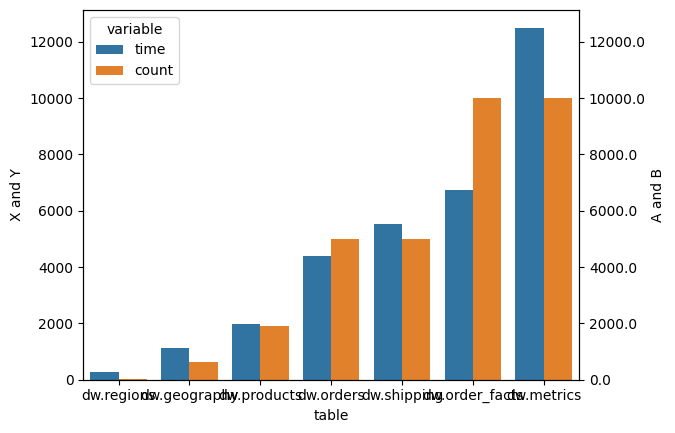

In [111]:
mask = df.variable.isin(['time'])
scale = int(df[~mask].value.mean()
            /df[mask].value.mean())
df.loc[mask, 'value'] = df.loc[mask, 'value']*scale


fig, ax1 = plt.subplots()
g = sns.barplot(x='table', y="value", hue="variable",\
                data=df, ax=ax1)

# Create a second y-axis with the scaled ticks
ax1.set_ylabel('X and Y')
ax2 = ax1.twinx()

# Ensure ticks occur at the same positions, then modify labels
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(np.round(ax1.get_yticks()/scale,1))
ax2.set_ylabel('A and B')

plt.show()

In [35]:
times

{'dw.regions': 0.012001276016235352,
 'dw.geography': 0.04896116256713867,
 'dw.products': 0.08499526977539062,
 'dw.orders': 0.19024276733398438,
 'dw.shipping': 0.23982477188110352,
 'dw.order_facts': 0.2927985191345215,
 'dw.metrics': 0.5426931381225586}

In [36]:
amounts

{'dw.customers': 793,
 'dw.regions': 4,
 'dw.geography': 632,
 'dw.products': 1894,
 'dw.orders': 5009,
 'dw.shipping': 5009,
 'dw.order_facts': 9994,
 'dw.metrics': 9994}